In [46]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [47]:
data_reliability = pd.read_csv("../data/reliability_synthetic.csv")
display(data_reliability.head())

,Device_ID,Test_Type,Stress_Temperature_C,Stress_Voltage_V,Failure_Time_Hours,Censored,Batch_ID
0,D0001,HTOL,125,4.5,624.701,0,B4
1,D0002,HTOL,125,4.5,992.238,0,B4
2,D0003,HTOL,125,4.5,522.748,0,B3
3,D0004,HTOL,125,4.5,465.29,0,B2
4,D0005,HTOL,125,4.5,287.708,0,B2


In [48]:
data_reliability.shape

(560, 7)

,Device_ID,Test_Type,Stress_Temperature_C,Stress_Voltage_V,Failure_Time_Hours,Censored,Batch_ID
count,560,560,560,560,560,560,560
unique,560,3,NaN,NaN,NaN,NaN,4
top,D0001,HTOL,NaN,NaN,NaN,NaN,B3
freq,1,320,NaN,NaN,NaN,NaN,151
mean,NaN,NaN,102.857,3.18571,848.561,0.392857,NaN
std,NaN,NaN,61.7489,2.08405,484.947,0.488822,NaN
min,NaN,NaN,-40,0,40.8678,0,NaN
25%,NaN,NaN,85,0,375.982,0,NaN
50%,NaN,NaN,125,4.5,925.696,0,NaN
75%,NaN,NaN,150,5,1200,1,NaN


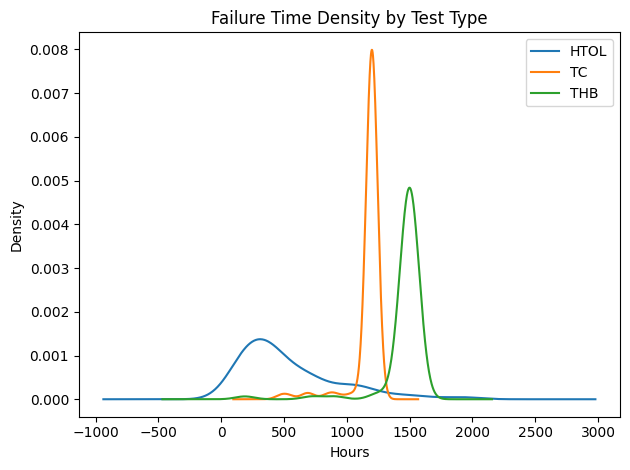

In [49]:
display(data_reliability.describe(include="all"))

# histogram by test type
plt.figure()
for tt, sub in data_reliability.groupby("Test_Type"):
    sub["Failure_Time_Hours"].plot(kind="kde", label=tt)
plt.title("Failure Time Density by Test Type")
plt.xlabel("Hours"); plt.legend(); plt.tight_layout()
plt.savefig("../results/density_by_testtype.png", dpi=150); plt.show()

In [50]:
data_reliability.columns

Index(['Device_ID', 'Test_Type', 'Stress_Temperature_C', 'Stress_Voltage_V', 'Failure_Time_Hours', 'Censored', 'Batch_ID'], dtype='object')

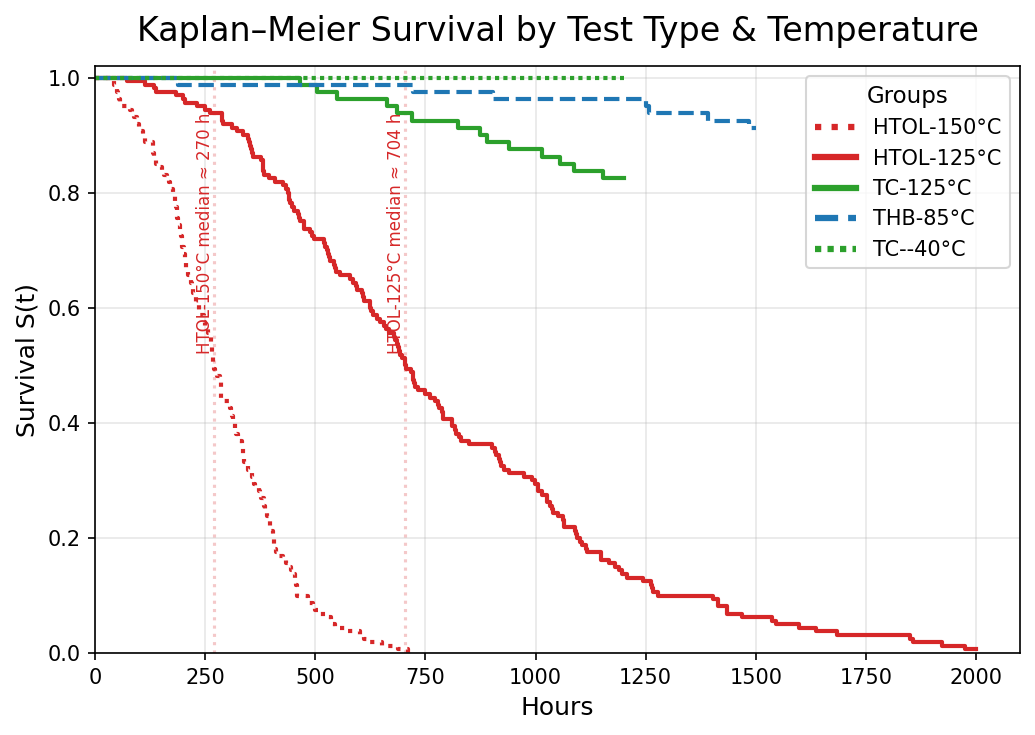

,Test_Type,Temp_C,median_hours
1,HTOL,125,703.985
0,HTOL,150,269.957
4,TC,-40,inf
2,TC,125,inf
3,THB,85,inf


In [51]:
df = data_reliability.copy()

# --- styling maps ---
palette = {"HTOL": "#d62728", "THB": "#1f77b4", "TC": "#2ca02c"}  # fixed by test type
linestyles = {-40: (0, (1, 1)), 85: "--", 125: "-", 150: ":"}     # by temperature

# Order groups in a logical way for legend/readability
preferred_order = [("HTOL", 150), ("HTOL", 125), ("TC", 125), ("THB", 85), ("TC", -40)]

groups = df.groupby(["Test_Type", "Stress_Temperature_C"])
km = KaplanMeierFitter()

plt.figure(figsize=(7, 5), dpi=150)

median_rows = []  # collect median survival per group

# Plot in preferred order if present, then any remaining groups
seen = set()
ordered_keys = [g for g in preferred_order if g in groups.groups]
ordered_keys += [k for k in groups.groups.keys() if k not in set(ordered_keys)]

for (tt, T) in ordered_keys:
    sub = groups.get_group((tt, T)).sort_values("Failure_Time_Hours")
    label = f"{tt}-{T}°C"

    km.fit(
        durations=sub["Failure_Time_Hours"],
        event_observed=1 - sub["Censored"],
        label=label
    )

    # main KM curve
    km.plot(
        ci_show=False,
        color=palette.get(tt, "black"),
        ls=linestyles.get(T, "-"),
        linewidth=2
    )

    # capture median survival if it exists (curve crosses 0.5)
    med = km.median_survival_time_
    if np.isfinite(med):
        plt.axvline(med, color=palette.get(tt, "black"), ls=":", alpha=0.25)
        plt.text(
            med, 0.52, f"{label} median ≈ {med:.0f} h",
            rotation=90, va="bottom", ha="right", fontsize=8, color=palette.get(tt, "black")
        )
        median_rows.append({"Test_Type": tt, "Temp_C": T, "median_hours": float(med)})
    else:
        median_rows.append({"Test_Type": tt, "Temp_C": T, "median_hours": np.inf})

plt.title("Kaplan–Meier Survival by Test Type & Temperature", fontsize=16, pad=12)
plt.xlabel("Hours", fontsize=12)
plt.ylabel("Survival S(t)", fontsize=12)
plt.grid(alpha=0.3)
plt.ylim(0, 1.02); plt.xlim(left=0)
leg = plt.legend(frameon=True, title="Groups", fontsize=10, title_fontsize=11, loc="upper right")
for line in leg.get_lines(): line.set_linewidth(3)

plt.tight_layout()
plt.savefig("../results/km_by_group_publication.png", dpi=200)
plt.show()

# Save medians for your results folder (handy in README/CL)
med_df = pd.DataFrame(median_rows).sort_values(["Test_Type","Temp_C"])
med_df.to_csv("../results/km_medians_by_group.csv", index=False)
med_df

In [52]:
import numpy as np
import pandas as pd
from reliability.Fitters import Fit_Weibull_2P

results = []
groups = data_reliability.groupby(["Test_Type", "Stress_Temperature_C", "Stress_Voltage_V"])
for (tt, T, V), sub in groups:
    failures = sub.loc[sub["Censored"] == 0, "Failure_Time_Hours"].values
    censored = sub.loc[sub["Censored"] == 1, "Failure_Time_Hours"].values

    if len(failures) < 3:
        continue  # skip tiny groups

    fit = Fit_Weibull_2P(
        failures=failures,
        right_censored=censored if len(censored) > 0 else None,
        show_probability_plot=False,
        print_results=False
    )
    results.append({
        "Test_Type": tt,
        "Temp_C": T,
        "Volt_V": V,
        "n": len(sub),
        "failures": int(len(failures)),
        "censored": int(len(censored)),
        "beta_shape": float(fit.results["beta"]),
        "eta_scale": float(fit.results["eta"]),
        "MTTF": float(fit.results["MTTF"]),
    })

res_df = pd.DataFrame(results).sort_values(["Test_Type","Temp_C","Volt_V"])
display(res_df)
res_df.to_csv("../results/weibull_group_fits.csv", index=False)


KeyError: 'beta'